# Projet ML Régression



## Importation des bibliothèques utilisés

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

## Importation de la base de donnée

In [2]:
mar = pd.read_csv('..\data\water_quality.csv')
'print(mar)'
mar.columns
print(mar.head())
mar.shape

    Timestamp  Record number  Average Water Speed  Average Water Direction  \
0  2023-08-04           1468                4.834                   73.484   
1  2023-08-04           1469                2.544                  106.424   
2  2023-08-04           1470                1.260                  156.755   
3  2023-08-04           1471                0.760                  281.754   
4  2023-08-04           1472                3.397                  244.637   

   Chlorophyll  Chlorophyll [quality]  Temperature  Temperature [quality]  \
0        1.621                    NaN       20.018                    NaN   
1        1.959                    NaN       19.986                    NaN   
2        1.620                    NaN       20.001                    NaN   
3        1.761                    NaN       19.983                    NaN   
4        1.635                    NaN       19.986                    NaN   

   Dissolved Oxygen  Dissolved Oxygen [quality]  \
0             7.4

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Martin Laporte\AppData\Local\Temp\ipykernel_16920\3239622886.py:1: SyntaxWarning: invalid escape sequence '\d'
  mar = pd.read_csv('..\data\water_quality.csv')


(30894, 20)

## Changement des timestamps

Ce changement à été fait précédemment, car lacolonne timestamp était sous la forme date heure minute seconde, ce qui n'était pas pertinent, je l'ai donc changé en juste une colonne de date, sous la forme yyyy-mm-dd.

## Visualisation des différentes données 

Ici on peut voir la répartition ds différentes données composants notre base.

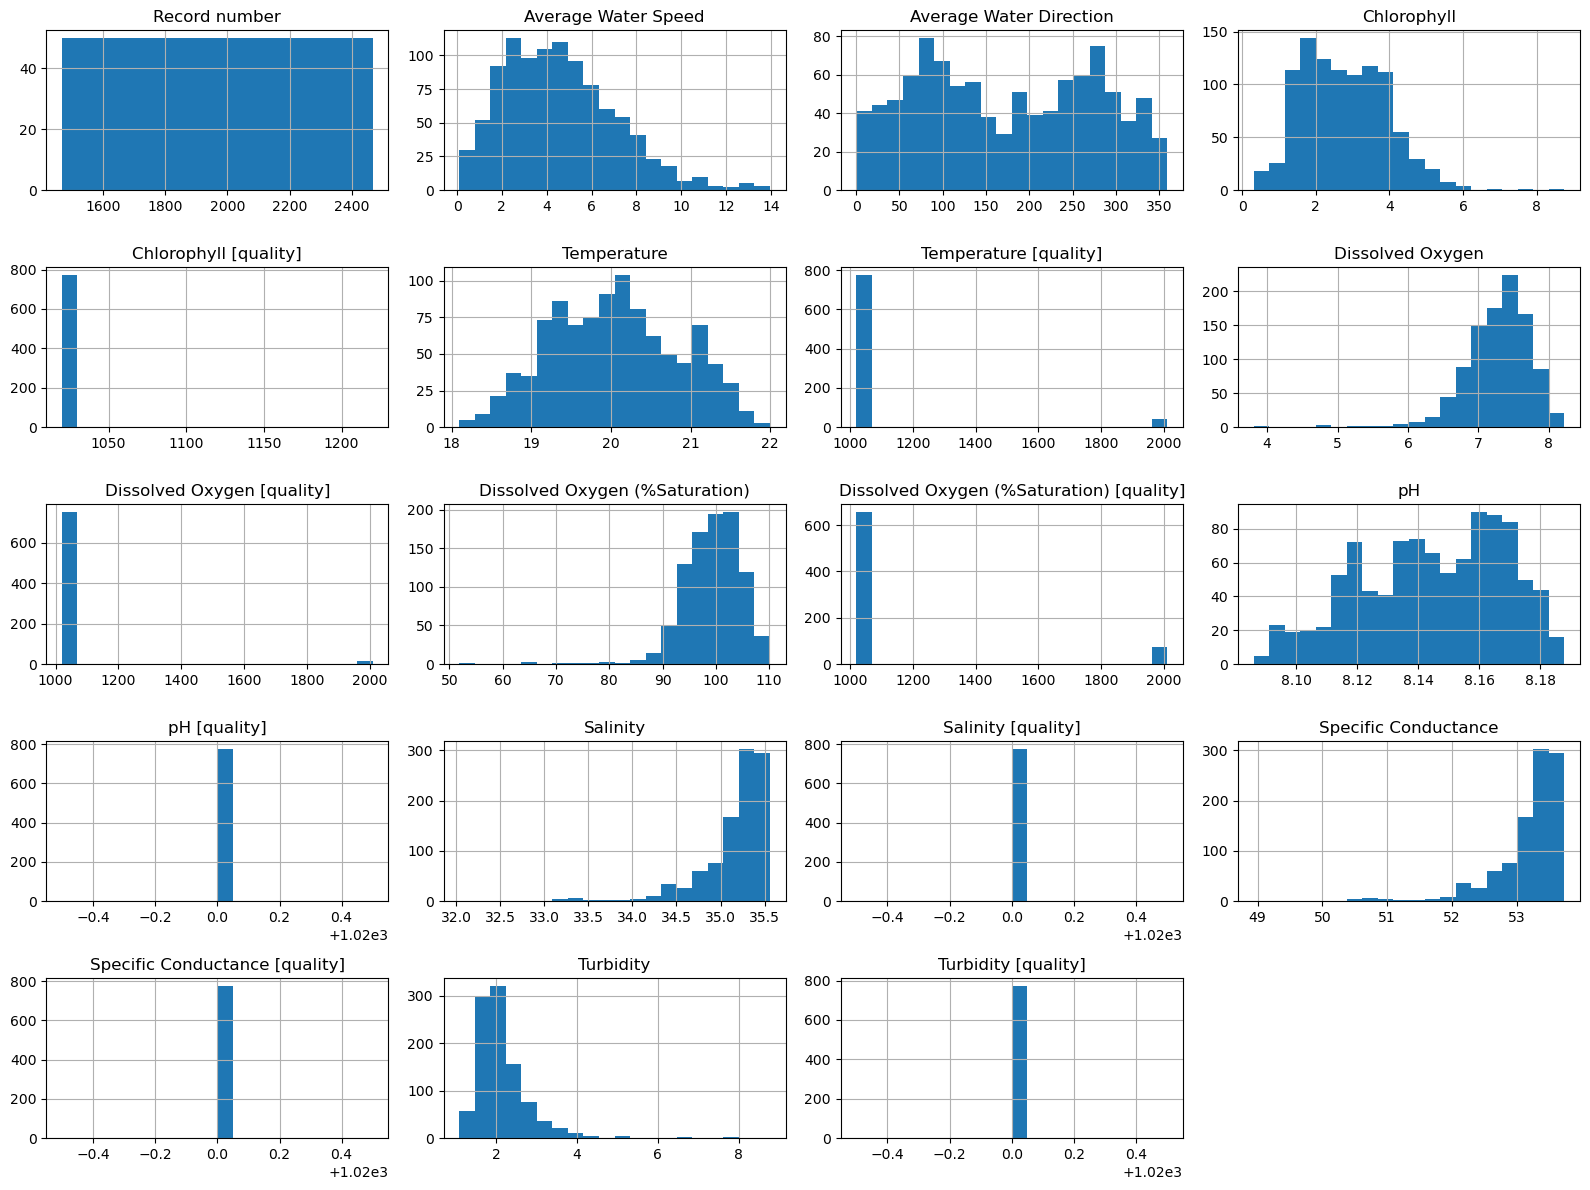

In [3]:
mar_sample = mar.head(1000)
mar_sample.hist(figsize=(16, 12), bins=20)
plt.tight_layout()
plt.show()

## Visualisation des outliers

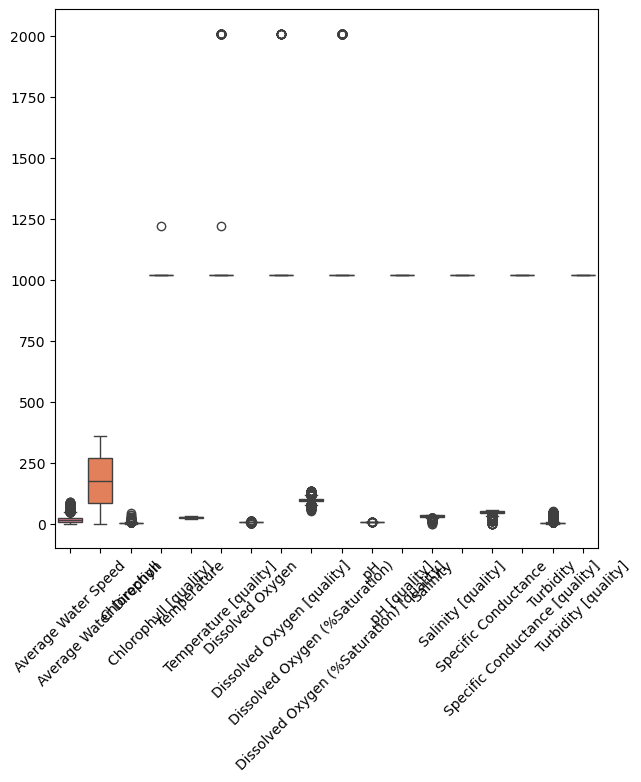

In [4]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=mar.drop(columns=['Timestamp', 'Record number']))
plt.xticks(rotation=45)
plt.show()

Chlorophyll [quality], Dissolved Oxygen [quality], ainsi que d’autres colonnes de type “quality” présentent des valeurs très élevées, atteignant jusqu’à 2000. Cela suggère probablement des valeurs codées pour signaler une qualité ou un seuil de mesure, et non des mesures physiques continues. Ces colonnes pourraient être traitées séparément ou exclues.

La variable Average Water Speed présente également des outliers visibles, bien que ses valeurs restent dans une plage raisonnable (en dessous de 400). Cela indique une variabilité importante dans la vitesse de l’eau, mais pas nécessairement des erreurs.

D’autres variables comme pH, Temperature, Turbidity ou Salinity semblent globalement bien réparties, avec peu ou pas d’outliers notables.

Ce graphique met en évidence la présence de valeurs extrêmes, en particulier dans les colonnes de qualité. Il est donc essentiel de :
Vérifier la signification exacte de ces colonnes "quality" pour éviter de mal interpréter des valeurs de codage.
Nettoyer ou normaliser les données, notamment pour les modèles sensibles aux outliers.
Éventuellement filtrer ou transformer les colonnes fortement déséquilibrées avant modélisation.

## Elimination des outliers

In [5]:
missing_values = mar.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values)

mar = mar.dropna()

mar.isnull().sum()
z_scores = stats.zscore(mar.select_dtypes(include='number'))

outliers = (z_scores > 3).sum(axis=1)
outlier_rows = mar[outliers > 0]
print(outlier_rows)

Dissolved Oxygen (%Saturation) [quality]    5950
Dissolved Oxygen (%Saturation)              5749
Temperature [quality]                       5344
Temperature                                 5164
Dissolved Oxygen [quality]                  4524
Dissolved Oxygen                            4300
Salinity [quality]                          4182
Salinity                                    3958
Turbidity [quality]                         2224
Turbidity                                   2000
Specific Conductance [quality]              1591
Specific Conductance                        1367
pH [quality]                                1308
pH                                          1084
Chlorophyll [quality]                        808
Chlorophyll                                  585
Average Water Speed                           20
Average Water Direction                        1
dtype: int64
        Timestamp  Record number  Average Water Speed  \
230    2023-08-09           1698                

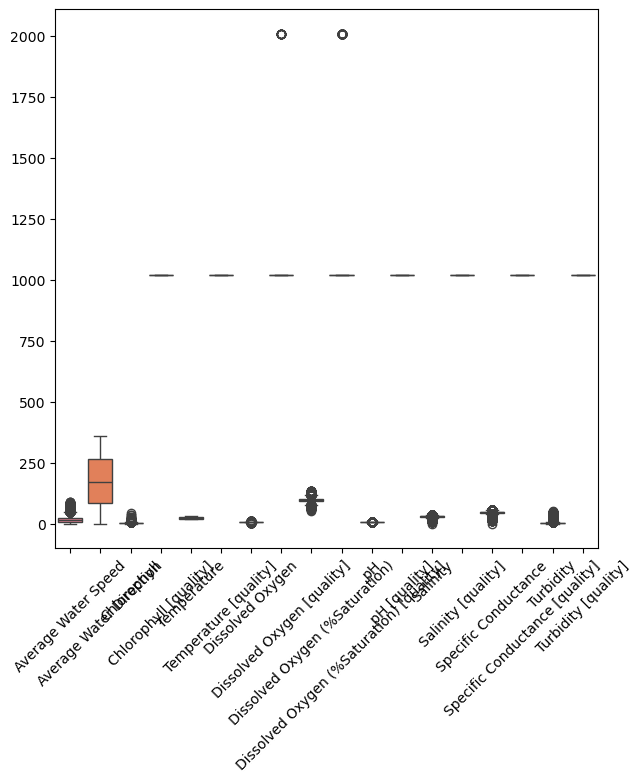

In [6]:
plt.figure(figsize=(7, 7))
sns.boxplot(data=mar.drop(columns=['Timestamp', 'Record number']))
plt.xticks(rotation=45)
plt.show()

## Affichage de la matrice de corrélation

On choisit de laisser tomber les colonnes 'quality' car elles ne nous sont pas importantes pour ce que nous cherchons à faire.

,Turbidity,pH,Salinity,Dissolved Oxygen,Temperature,Chlorophyll,Specific Conductance,Average Water Speed,Average Water Direction,Dissolved Oxygen (%Saturation)
count,19149.000000,19149.00000,19149.000000,19149.000000,19149.000000,19149.000000,19149.000000,19149.000000,19149.000000,19149.000000
mean,4.543217,8.09484,30.128649,6.811035,24.090088,2.812142,46.387312,16.353249,175.725639,96.067649
std,4.768920,0.08057,3.420853,0.629402,3.770534,1.809513,4.762702,13.033747,103.553981,8.352748
min,0.365000,7.30900,0.158000,3.806000,17.000000,0.106000,0.334000,0.016000,0.020000,51.836000
25%,2.630000,8.05300,28.816000,6.407000,20.661000,1.564000,44.561000,6.340000,85.313000,91.147000
50%,3.236000,8.10800,29.744000,6.839000,24.839000,2.425000,45.884000,12.805000,171.286000,95.864000
75%,4.229000,8.15400,31.515000,7.245000,27.272000,3.585000,48.420000,22.943000,266.066000,101.089000
max,49.869000,8.25300,36.000000,9.260000,32.063000,43.301000,54.506000,89.912000,359.994000,134.082000


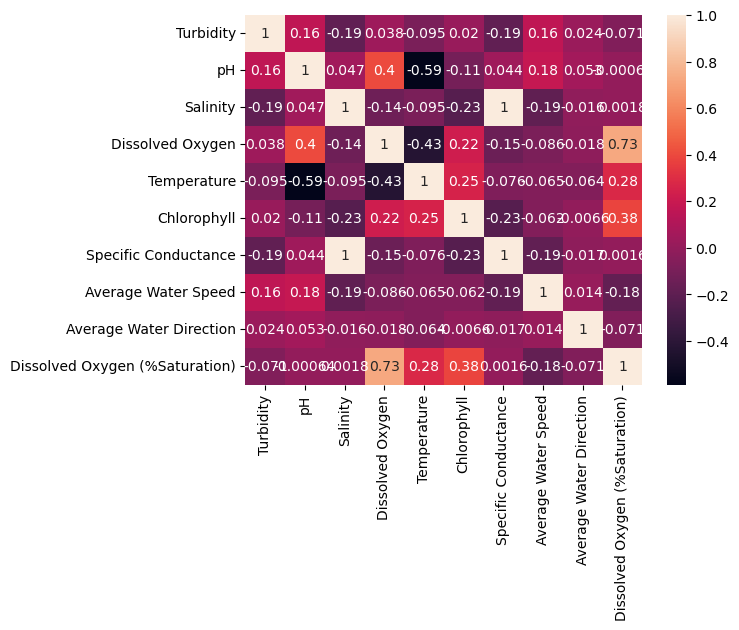

In [7]:
mar_features = ['Turbidity', 'pH', 'Salinity', 'Dissolved Oxygen', 'Temperature','Chlorophyll', 'Specific Conductance', 'Average Water Speed', 'Average Water Direction', 'Dissolved Oxygen (%Saturation)']
X = mar[mar_features]

matrice =X.corr()
sns.heatmap(matrice,annot=True)

X.describe()

L’objectif ici est d’identifier les variables ayant une influence significative sur la variable cible, à savoir Dissolved Oxygen (%Saturation), qui mesure le pourcentage de saturation de l’oxygène dissous dans l’eau.
Observations principales :

- La variable Dissolved Oxygen présente une corrélation très forte (0.73) avec la cible. Cela confirme qu’elle est étroitement liée au taux de saturation en oxygène et constitue une variable essentielle dans la modélisation.

- Chlorophyll affiche une corrélation modérée (0.38). Cela est cohérent avec le fait que la chlorophylle, indicateur de présence d’algues, est liée à la photosynthèse, donc à la production d’oxygène.

- Temperature montre une corrélation plus faible (0.28) mais toujours positive. Elle peut influencer la solubilité de l’oxygène dans l’eau.

- Les autres variables telles que pH, Turbidity, Salinity, ou encore la vitesse/direction de l’eau présentent des corrélations faibles ou nulles avec la cible, ce qui les rend moins prioritaires pour la prédiction.

## Normalisation des données

In [8]:
numeric_cols = ['Record number', 'Average Water Speed', 'Average Water Direction', 'Chlorophyll', 'Temperature','Dissolved Oxygen', 'pH', 'Salinity', 'Specific Conductance', 'Turbidity', 'Dissolved Oxygen (%Saturation)']
X = mar[mar_features]

scaler = MinMaxScaler()

mar[numeric_cols] = scaler.fit_transform(mar[numeric_cols])

print(mar.head())

      Timestamp  Record number  Average Water Speed  Average Water Direction  \
225  2023-08-09       0.000000             0.058935                 0.140524   
226  2023-08-09       0.000033             0.056421                 0.095924   
227  2023-08-09       0.000065             0.064741                 0.429298   
228  2023-08-09       0.000098             0.016842                 0.049512   
229  2023-08-09       0.000130             0.070381                 0.217041   

     Chlorophyll  Chlorophyll [quality]  Temperature  Temperature [quality]  \
225     0.033592                 1020.0     0.155746                 1020.0   
226     0.027619                 1020.0     0.159596                 1020.0   
227     0.048061                 1020.0     0.162185                 1020.0   
228     0.046441                 1020.0     0.169223                 1020.0   
229     0.056326                 1020.0     0.172011                 1020.0   

     Dissolved Oxygen  Dissolved Oxygen [qua

## Choix de la target et des features
Suite à l'analyse de la matrice de corrélation, on remarque que les features suivantes son les plus utiles pour pouvoir entrainés nos modèles de régression.

In [9]:
y = mar['Dissolved Oxygen (%Saturation)']

mar_features = ['Dissolved Oxygen', 'Temperature', 'Chlorophyll', 'pH']

In [10]:
print("shape of X : ", X.shape)
print("shape of y", y.shape)

shape of X :  (19149, 10)
shape of y (19149,)


In [11]:
y.describe()

count    19149.000000
mean         0.537797
std          0.101558
min          0.000000
25%          0.477969
50%          0.535321
75%          0.598850
max          1.000000
Name: Dissolved Oxygen (%Saturation), dtype: float64

In [12]:
X = mar[mar_features]

X.head()

,Dissolved Oxygen,Temperature,Chlorophyll,pH
225,0.747891,0.155746,0.033592,0.911017
226,0.733040,0.159596,0.027619,0.903602
227,0.756142,0.162185,0.048061,0.911017
228,0.752842,0.169223,0.046441,0.906780
229,0.789696,0.172011,0.056326,0.920551


## Splitting Dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## DecisionTreeRegressor

In [14]:
mar_Dtr = DecisionTreeRegressor(max_depth=5, random_state=1)
mar_Dtr.fit(X_train, y_train)

y_pred_Dtr = mar_Dtr.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_Dtr)
r2_dt = r2_score(y_test, y_pred_Dtr)
mae_dt = mean_absolute_error(y_test, y_pred_Dtr)
cross_val_Dtr = cross_val_score(mar_Dtr, X, y, cv = 5, scoring = 'neg_mean_squared_error')
cross_val_Dtr = - cross_val_Dtr

print(mar_Dtr.score(X_test, y_test))
print(f"Mean Squared Error: {mse_dt:.4f}")
print(f"R^2 Score: {r2_dt:.2f}")
print(f"Mean absolute Error: {mae_dt:.6f}")
print("Scores MSE sur chaque fold :", cross_val_Dtr)
print("Score MSE moyen :", np.mean(cross_val_Dtr))
print("Écart-type du score MSE :", np.std(cross_val_Dtr))

0.8907509981817545
Mean Squared Error: 0.0011
R^2 Score: 0.89
Mean absolute Error: 0.026636
Scores MSE sur chaque fold : [0.0032703  0.00322766 0.00168607 0.0015508  0.00453687]
Score MSE moyen : 0.002854339888588092
Écart-type du score MSE : 0.0011142151074692009


1. R² Score (0.89) :

    Le R², ou coefficient de détermination, indique que 89 % de la variance de la variable cible est expliquée par le modèle.

    C’est une très bonne performance : le modèle capture efficacement les tendances du phénomène étudié (ici, l’oxygène dissous en % de saturation).

 2. Erreur quadratique moyenne (MSE = 0.0011) :

    Très faible, ce qui indique que les erreurs de prédiction sont en moyenne très petites en valeur absolue.

    C’est une mesure sensible aux grosses erreurs : sa petite valeur montre qu’il n’y a pas ou peu de grandes erreurs isolées.

3. Erreur absolue moyenne (MAE = 0.0266) :

    En moyenne, le modèle se trompe de 2.66 % en prédiction de Dissolved Oxygen (%Saturation).

    Donc, si la saturation réelle est 75 %, le modèle pourrait prédire ~72.34 % ou ~77.66 % — un écart modeste et tolérable dans la plupart des cas environnementaux.

Pour la validation croisée : 
- Moyenne : 0.00285 → cohérente avec le MSE global, ce qui montre que le modèle généralise bien.
- Écart-type : 0.00111 → variation modérée des scores d’un fold à l’autre.
- Cela indique que les performances du modèle sont relativement stables selon les sous-ensembles de données.

Ces interprétations seront les mêmes pour les autres modèles à tester, nous n'allons donc pas faire une analyse aussi approfondie pour les autres.

## Random Forest Regressor

In [15]:
rf_model = RandomForestRegressor(
    n_estimators=100,      
    max_depth=5,          
    min_samples_leaf=2,    
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
cross_val_rf = cross_val_score(rf_model, X, y, cv = 5, scoring = 'neg_mean_squared_error')
cross_val_rf = - cross_val_rf

print(rf_model.score(X_test, y_test))
print(f"Random Forest - Mean Squared Error: {mse_rf:.4f}")
print(f"Random Forest - R^2 Score: {r2_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.4f}")

print("Scores MSE sur chaque fold :", cross_val_rf)
print("Score MSE moyen :", np.mean(cross_val_rf))
print("Écart-type du score MSE :", np.std(cross_val_rf))

0.9328066549666263
Random Forest - Mean Squared Error: 0.0007
Random Forest - R^2 Score: 0.9328
Mean Absolute Error: 0.0207
Scores MSE sur chaque fold : [0.00259239 0.00262988 0.00101929 0.00134323 0.00370388]
Score MSE moyen : 0.002257732190497459
Écart-type du score MSE : 0.0009707612915107278


## Gaussian Process Regressor

In [16]:
mar_Gpr = GaussianProcessRegressor()
mar_Gpr.fit(X_train, y_train)

y_pred_Gnb = mar_Gpr.predict(X_test)

mse_Gnb = mean_squared_error(y_test, y_pred_Gnb)
r2_Gnb = r2_score(y_test, y_pred_Gnb)
mae_Gnb = mean_absolute_error(y_test, y_pred_Gnb)
cross_val_Gpr = cross_val_score(mar_Gpr, X, y, cv = 5, scoring = 'neg_mean_squared_error')
cross_val_Gpr = -cross_val_Gpr
print(mar_Gpr.score(X_test, y_test))
print(f"GaussianNB - Mean Squared Error: {mse_Gnb:.4f}")
print(f"GaussianNB - R^2 Score: {r2_Gnb:.4f}")
print(f"GaussianNB - Mean Absolute Error: {mae_Gnb:.4f}")
print('Dissolved Oxygen (%)')

print("Scores MSE sur chaque fold :", cross_val_Gpr)
print("Score MSE moyen :", np.mean(cross_val_Gpr))
print("Écart-type du score MSE :", np.std(cross_val_Gpr))

0.9820331858025038
GaussianNB - Mean Squared Error: 0.0002
GaussianNB - R^2 Score: 0.9820
GaussianNB - Mean Absolute Error: 0.0090
Dissolved Oxygen (%)
Scores MSE sur chaque fold : [2.83927343e-03 1.71836766e+01 2.28833447e-04 9.19917750e-04
 5.98986973e-03]
Score MSE moyen : 3.438730896639059
Écart-type du score MSE : 6.87247313636966


## GradientBoostingRegressor

In [17]:
mar_Gbr = GradientBoostingRegressor(n_estimators=100)
mar_Gbr.fit(X_train, y_train)
mar_Gbr.score(X_test, y_test)
print(mar_Gbr.__class__.__name__, mar_Gbr.score(X_test, y_test))
y_pred_Gbr = mar_Gbr.predict(X_test)

mse_Gradient = mean_squared_error(y_test, y_pred_Gbr)
r2_Gradient = r2_score(y_test, y_pred_Gbr)
mae_Gradient = mean_absolute_error(y_test, y_pred_Gbr)
cross_val_Gbr = cross_val_score(mar_Gbr, X, y, cv = 5, scoring = 'neg_mean_squared_error')
cross_val_Gbr = -cross_val_Gbr

print(f"GaussianNB - Mean Squared Error: {mse_Gradient:.4f}")
print(f"GaussianNB - R^2 Score: {r2_Gradient:.4f}")
print(f"GaussianNB - Mean Absolute Error: {mae_Gradient:.4f}")

print("Scores MSE sur chaque fold :", cross_val_Gbr)
print("Score MSE moyen :", np.mean(cross_val_Gbr))
print("Écart-type du score MSE :", np.std(cross_val_Gbr))

GradientBoostingRegressor 0.9757241327237463
GaussianNB - Mean Squared Error: 0.0003
GaussianNB - R^2 Score: 0.9757
GaussianNB - Mean Absolute Error: 0.0116
Scores MSE sur chaque fold : [0.00282151 0.00098048 0.0004433  0.00047777 0.00188487]
Score MSE moyen : 0.0013215848953278056
Écart-type du score MSE : 0.0009128878073711307


Les performances ont été comparées selon trois critères : le score R² sur l’ensemble de test, l’erreur quadratique moyenne (MSE), et l’erreur absolue moyenne (MAE). Une validation croisée à 5 plis (cross-validation) a également été réalisée pour évaluer la stabilité de chaque modèle.

Les résultats sont résumés comme suit :

- Decision Tree Regressor : modèle simple avec un score R² de 0.89. Il obtient un MSE moyen de 0.00285 en validation croisée. Il reste un bon point de départ, mais ses performances sont limitées.

- Random Forest Regressor : amélioration notable avec un R² de 0.93 et un MSE plus faible. Il montre également une bonne stabilité en validation croisée, ce qui en fait un modèle robuste.

- Gradient Boosting Regressor : ce modèle obtient de très bonnes performances avec un R² de 0.975, un faible MSE et une très bonne stabilité entre les différents folds. Il parvient à capturer des relations complexes sans surapprendre.

- Gaussian Process Regressor : bien qu’il atteigne un R² exceptionnel de 0.982 et une erreur très faible sur le jeu de test, ses résultats en validation croisée sont instables. Le MSE moyen est beaucoup plus élevé, avec une grande variance, indiquant un risque de surapprentissage.


On peut donc dire que le Gradient Boosting Regressor s’est avéré être le meilleur modèle pour ce projet. Il combine précision, stabilité et capacité de généralisation, ce qui en fait le choix le plus fiable pour une application réelle sur des données de qualité de l’eau.

## Tests sur de nouvelles données

Nous allons maintenant tester nos modèles sur des données choisis arbitrairement. Ces données doivent être normalisés, il ne faut donc pas donner aux modèles des données brutes.

In [19]:
trained_models = {
    "DecisionTreeRegressor": mar_Dtr,
    "RandomForestRegressor": rf_model,    
    "GaussianProcessRegressor": mar_Gpr,
    "GradientBoostingRegressor" : mar_Gbr
}

scaler = MinMaxScaler()
scaler.fit(X_train[mar_features ])

def tester_nouvelle_eau(data_brute, models, scaler, mar_features):

    df = pd.DataFrame([data_brute])
    df = df[mar_features]
    df_scaled = pd.DataFrame(scaler.transform(df), columns=mar_features)

    print("Prédictions des modèles :")
    for name, model in models.items():
        prediction = model.predict(df_scaled)[0]
        print(f"{name:25} → Prédiction : {prediction:.3f}")

tester_nouvelle_eau (
    data_brute={
        'Dissolved Oxygen': 0.80263,
        'Temperature': 0.2017,
        'Chlorophyll': 0.079515,
        'pH': 0.929842
    }, 
    models=trained_models,
    scaler=scaler,
    mar_features = ['Dissolved Oxygen', 'Temperature', 'Chlorophyll', 'pH']
)

Prédictions des modèles :
DecisionTreeRegressor     → Prédiction : 0.609
RandomForestRegressor     → Prédiction : 0.617
GaussianProcessRegressor  → Prédiction : 0.686
GradientBoostingRegressor → Prédiction : 0.659


Concordance entre les modèles :
- Les quatre modèles donnent des prédictions situées dans une plage relativement étroite : entre 0.609 et 0.686.
- Cette convergence est un bon indicateur de robustesse : les modèles, malgré leurs mécanismes internes différents, perçoivent des tendances similaires dans les données.

Modèle le plus optimiste :
- Le Gaussian Process Regressor prévoit la valeur la plus élevée (0.686), ce qui peut refléter sa plus grande sensibilité aux petites variations dans les données d’entrée.
- Toutefois, dans l’analyse précédente, ce modèle montrait une forte instabilité lors de la validation croisée, ce qui appelle à la prudence dans l’interprétation de ses prédictions.

Un taux de saturation en oxygène dissous aux alentours de 61–68%, comme le suggèrent les modèles, peut indiquer un niveau modérément faible d’oxygénation :
- < 60 % : souvent associé à une eau pauvre en oxygène, pouvant stresser la faune aquatique.
- 60–80 % : zone intermédiaire, acceptable dans certaines conditions, mais peut suggérer des déséquilibres (eutrophisation, pollution organique…).
- plus de 80 % : généralement considéré comme bon à excellent.

Ainsi, dans ce cas donnée arbitrairement, la valeur prédite est à surveiller.

### Conclusion

Les prédictions sur cette nouvelle observation montrent un consensus modéré entre les modèles, indiquant un niveau d'oxygène dissous légèrement inférieur à l’idéal. Les meilleurs modèles en termes de précision et de stabilité (Random Forest et Gradient Boosting) suggèrent une valeur aux alentours de 0.62–0.66, ce qui mérite une attention particulière, notamment si d'autres paramètres environnementaux aggravent la situation.